In [ ]:
<p style="font-size:20px; text-align:center">Assignment 1</p>
<p style="font-size:18px; text-align:center">CS6910: Fundamentals of Deep Learning</p>
<p>Sujay Bokil: ME17B120<br>
Avyay Rao: ME17B130</p>

In [7]:
# import necessary libraries
from copy import deepcopy
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

# import templates that we have created to make different kinds of layers, losses, optimizers etc.
from sujay.templates import AutoDiffFunction, Layer, Loss, Optimizer

In [ ]:
# Outline of the Framework

## Template Classes

In [15]:
"""
Module to create template classes for Autodifferentiable losses/activations/layers
"""

class AutoDiffFunction():
    """Format for any function in general which has to be auto-differentiable
    """

    def __init__(self, *args, **kwds) -> None:
        self.saved_for_backward = {}
        self.grad = {}

    def __call__(self, *args, **kwds):

        output = self.forward(*args, **kwds)
        self.grad = self.compute_grad(*args, **kwds)
        return output

    def forward(self, *args, **kwds):
        pass

    def compute_grad(self, *args, **kwds):
        pass

    def backward(self, *args, **kwds):
        pass


class Layer(AutoDiffFunction):
    """Format to create your own custom layer for the model
    """
    def __init__(self, *args, **kwds) -> None:
        super().__init__(*args, **kwds)

        self.weights = {}
        self.optimizer = None

    def initialize_weights(self, *args, **kwds):
        pass

    def update_weights(self):

        self.optimizer.step(self)


class Loss(AutoDiffFunction):
    """Format to create a custom loss function
    """

    def forward(self, y_true, y_pred):
        pass 

    def backward(self):
        return self.grad["x"]

    def compute_grad(self, y_true, y_pred):
        pass


class Optimizer():
    """Format to create a custom optimizer
    """
    def __init__(self, *args, **kwds):
        self.remember = {}
        pass

    def add_params(self, *args, **kwds):
        pass

    def step(self, layer):
        pass    

In [ ]:
## Activation Functions

For this assignment we implement the following activation functions:

1. Sigmoid activation

$$y = \sigma(x) = \frac{1}{1 + e^{-x}}$$

$$\frac{dy}{dx} = \frac{-e^{-x}}{(1 + e^{-x})^2} = \sigma(x)(1 - \sigma(x))$$

2. ReLU activation

$$y = ReLU(x) = max(0, x)$$

$$ \frac{dy}{dx} = \left\{
\begin{array}{ll}
      1 & x\geq 0\\
      0 & x\leq 0 \\
\end{array} 
\right.$$

3. Tanh activation
$$y = tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$
$$\frac{dy}{dx} = \frac{4}{(e^x + e^{-x})^2} = 1 - (tanh(x))^2$$

In [16]:
class Sigmoid(AutoDiffFunction):
    """ 
    Represents the Sigmoid Activation function
    """
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        self.saved_for_backward = 1/(1 + np.exp(-x))
        return self.saved_for_backward

    def compute_grad(self, x):
        y = self.saved_for_backward

        return {"x": y*(1-y)}

    def backward(self, dy):
        return dy * self.grad["x"]      


class RelU(AutoDiffFunction):
    """ 
    Represents the RelU Activation function
    """
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        self.saved_for_backward = np.where(x>0.0, 1.0, 0.0)

        return x * self.saved_for_backward

    def compute_grad(self, x):
        return {"x": self.saved_for_backward}

    def backward(self, dy):
        return dy * self.grad["x"]
    
class Tanh(AutoDiffFunction):
    """ 
    Represents the Tanh Activation function
    """
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        self.saved_for_backward = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

        return self.saved_for_backward

    def compute_grad(self, x):
        y = self.saved_for_backward

        return {"x": 1 - y**2}

    def backward(self, dy):
        return dy * self.grad["x"]
    
class Softmax(AutoDiffFunction):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        v = np.exp(x)
        self.saved_for_backward = v

        return v / np.sum(v, axis=1, keepdims=True)

    def compute_grad(self, x):
        pass

    def backward(self, dy):
        return dy * self.grad["x"]

In [ ]:
## Layers

For this assignment, we only use fully connected OR Dense layers where each input neuron is connected to each output neuron, along with a bias unit. Below is a representation of a fully connected layer.

![Representation of a fully connected layer](FullyConnectedLayer.png)

The equation for such a layer is simply

$$y = FullyConnected(x) = wx + b$$

$$\frac{dy}{dw} = x^T \quad\frac{dy}{dx} = w^T  \quad\frac{dy}{db} = 1$$

In [17]:
class FC(Layer):
    def __init__(self, in_dim, out_dim, weight_decay=None, init_method="random") -> None:
        super().__init__()
        self.weight_decay = weight_decay
        self.init_method = init_method
        self.initialize_weights(in_dim, out_dim)

    def initialize_weights(self, in_dim, out_dim):
        
        if self.init_method == "random":
            scaling_factor = 1/np.sqrt(in_dim)
            self.weights["w"] = np.random.randn(in_dim, out_dim) * scaling_factor
            self.weights["b"] = np.random.randn(1, out_dim) * scaling_factor
        elif self.init_method == "xavier":
            lim = np.sqrt(6 / (in_dim + out_dim))
            self.weights["w"] = np.random.uniform(low=-lim, high=lim, size=(in_dim, out_dim))
            self.weights["b"] = np.random.uniform(low=-lim, high=lim, size=(1, out_dim))

    def compute_grad(self, x):
        
        gradients = {}

        # y = x * w + b        
        # we compute gradients wrt w and x 
        # gradient wrt b is not required explicitly since we know that it's value is 1
        gradients["w"] = self.saved_for_backward["x"].T
        gradients["x"] = self.weights["w"].T

        return gradients


    def forward(self, x):
        output = x @ self.weights["w"] + self.weights["b"]
        self.saved_for_backward["x"] = x
        
        return output

    def backward(self, dy):
        
        # calculating gradients wrt input to pass on to previous layer for backprop
        dx = dy @ self.grad["x"]
        
        # calculating gradients wrt weights
        dw = self.grad["w"] @ dy
        db = np.sum(dy, axis=0, keepdims=True)

        # accomodating for weight_decay / regularization
        if self.weight_decay:
            dw = dw + 2 * self.weight_decay * self.weights["w"]
            db = db + 2 * self.weight_decay * self.weights["b"]

        self.absolute_gradients = {"w": dw, "b": db}

        return dx

    def update_weights(self):
        self.optimizer.step(self)

In [ ]:
## Loss Functions

The loss function dictates how good the output of the neural network is. Since we use MNIST dataset, our job is classification and hence we use the Categorical CrossEntropy loss function. We also have created the Mean Squared Error loss function to check how it performs for a classification task for which it's not meant. 

#### 1) CrossEntropy Loss

$$L(p, y) = \Sigma_{i=1}^{N} \Sigma_{k=1}^{K} y_{ik} \log p_{ik}$$ 

where $$y_{ik} = \left\{
\begin{array}{ll}
      1 & x \in class-k\\
      0 & else \\
\end{array} 
\right.$$

$p_{ik} =$ probability that $i^{th}$ sample falls in $k^{th}$ class

In our implementation, the given loss function is applied along with the activation function for the last layer i.e. Softmax activation. It's formula is given by the following equation

$ f: [x_1, x_2, ... x_k] \rightarrow [p_1, p_2, ... p_k]$ such that $p_i = \frac{e^{x_i}}{\Sigma_{k=1}^{K} e^{x_i}}$

Now, to find the derivative of loss w.r.t input we have apply the chain rule. Let $p(x)$ represent the softmax activation and $L$ represent the loss. Then the expression turns out to be:

$$\frac{\partial L}{\partial x} = \frac{\partial L(p, y)}{\partial p} \frac{\partial p(x)}{\partial x} = p - y$$

#### 2) Mean Squared Loss OR L2 Loss

$$L(p, y) = \frac{1}{2b}\Sigma_{i=1}^{b} \Sigma_{k=1}^{K} (p_{ik} - y_{ik})^2$$

where $$y_{ik} = \left\{
\begin{array}{ll}
      1 & x \in class-k\\
      0 & else \\
\end{array} 
\right.$$

$p_{ik} =$ probability that $i^{th}$ sample falls in $k^{th}$ class

As above, the MSE loss is applied along with Softmax activation on the last layer. The combined derivative of MSE loss and softmax is given by:

$$\frac{\partial L}{\partial a_i^{(L)}} = \frac{\partial L(p, y)}{\partial p} \frac{\partial p(a_i^{(L)})}{\partial a_i^{(L)}} = \Sigma_{j=1}^{K} p_j(p_j - y_j)[\delta_{ij} - p_i]$$

where $$\delta_{ij} = \left\{
\begin{array}{ll}
      1 & i=j\\
      0 & else \\
\end{array} 
\right.$$

As can be seen from the expression, unlike for Cross Entropy loss the expression cannot be vectorised and individual components have to be separately calculated.

In [18]:
class CrossEntropyLossFromLogits(Loss):
    def __init__(self) -> None:
        super().__init__()
        self.n_classes = None

    @staticmethod
    def softmax(x):
        v = np.exp(x)
        return v / np.sum(v, axis=1, keepdims=True)

    def encode(self, y): 
        encoded_y = np.zeros(shape=(len(y), self.n_classes))

        for i in range(len(y)):
            encoded_y[i,y[i]] = 1

        return encoded_y

    def forward(self, y_pred, y_true):
         
        probabilities = self.softmax(y_pred)
        y_true_encoded = self.encode(y_true)

        loss_value = np.mean(np.sum(- y_true_encoded * np.log(probabilities), axis=1))

        self.saved_for_backward["probabilities"] = probabilities
        self.saved_for_backward["y_true"] = y_true_encoded

        return loss_value

    def compute_grad(self, y_pred, y_true):

        return {"x": self.saved_for_backward["probabilities"] - self.saved_for_backward["y_true"]}        


class MSELossFromLogits(Loss):
    def __init__(self) -> None:
        super().__init__()
        self.n_classes = None

    @staticmethod
    def softmax(x):
        v = np.exp(x)

        return v / np.sum(v, axis=1, keepdims=True)

    def encode(self, y): 
        encoded_y = np.zeros(shape=(len(y), self.n_classes))

        for i in range(len(y)):
            encoded_y[i,y[i]] = 1

        return encoded_y
    
    @staticmethod
    def indicator(i, j):
        ind = {True: 1, False: 0}
        return ind[i==j]

    def forward(self, y_pred, y_true):
         
        probabilities = self.softmax(y_pred)
        y_true_encoded = self.encode(y_true)

        loss_value = np.mean(np.sum((probabilities - y_true_encoded)**2, axis=1))

        self.saved_for_backward["probabilities"] = probabilities
        self.saved_for_backward["y_true"] = y_true_encoded

        return loss_value

    def compute_grad(self, y_pred, y_true):

        probs = self.saved_for_backward["probabilities"]
        labels = self.saved_for_backward["y_true"]
        grad = np.zeros(shape=(len(y_true), self.n_classes))
        
        for point_counter in range(len(y_true)):
            res = 0
            for i in range(self.n_classes):
                for j in range(self.n_classes):
                    
                    res = probs[point_counter, j] * (probs[point_counter, j] - labels[point_counter, j]) * (self.indicator(i,j) - probs[point_counter, i])
                
                grad[point_counter, i] = res
        
        return {"x": grad}

In [ ]:
## Optimizers

Optimizers basically denote how to make use of the gradients achieved through backpropogation to update the weights of the model. Based on the question, we have created the following 6 optimizers.

1) sgd<br>
2) momentum based gradient descent<br>
3) nesterov accelerated gradient descent<br>
4) rmsprop<br>
5) adam<br>
6) nadam<br>

All the default parameter values are taken from keras optimizers.

In [19]:
# 1. SGD OPTIMIZER
class SGD(Optimizer):
    def __init__(self, lr=1e-2):
        super().__init__()
        self.lr = lr

    def step(self, layer):

        for weight_name, _ in layer.weights.items():
            layer.weights[weight_name] = layer.weights[weight_name] - self.lr * layer.absolute_gradients[weight_name]
            
class Momentum(Optimizer):
    def __init__(self, lr=1e-3, gamma=0.9):
        super().__init__()
        self.lr = lr
        self.gamma = gamma
        
    def step(self, layer):
        
        #Initialise update history
        if self.remember == {}:
            for weight_name, weight in layer.weights.items():
                self.remember[weight_name] = {}
                self.remember[weight_name]["v"] = np.zeros_like(weight)
        
        #Momentum update rule
        for weight_name, weight in layer.weights.items():
            self.remember[weight_name]["v"] = self.gamma * self.remember[weight_name]["v"] + \
                                                self.lr * layer.absolute_gradients[weight_name]
            layer.weights[weight_name] = layer.weights[weight_name] - self.remember[weight_name]["v"]

class NAG(Optimizer):
    def __init__(self, lr=1e-3, gamma=0.9) -> None:
        super().__init__()
        self.lr = lr
        self.gamma = gamma 

    def step(self, layer):

# 2. MOMENTUM OPTIMIZER
class Momentum(Optimizer):
    def __init__(self, lr=1e-3, gamma=0.9):
        super().__init__()
        self.lr = lr
        self.gamma = gamma
        
    def step(self, layer):
        
        #Initialise update history
        if self.remember == {}:
            for weight_name, weight in layer.weights.items():
                self.remember[weight_name] = {}
                self.remember[weight_name]["v"] = np.zeros_like(weight)
        
        #Momentum update rule
        for weight_name, weight in layer.weights.items():
            self.remember[weight_name]["v"] = self.gamma * self.remember[weight_name]["v"] + \
                                                self.lr * layer.absolute_gradients[weight_name]
            layer.weights[weight_name] = layer.weights[weight_name] - self.remember[weight_name]["v"]

            
# 3. NESTEROV ACCELARATED GRADIENT OPTIMIZER
class NAG(Optimizer):
    def __init__(self, lr=1e-3, gamma=0.9):
        super().__init__()
        self.lr = lr
        self.gamma = gamma 

    def step(self, layer):

        if self.remember == {}:
            for weight_name, weight in layer.weights.items():
                self.remember[weight_name] = {}
                self.remember[weight_name]["v"] = np.zeros_like(weight)

        for weight_name, weight in layer.weights.items():
            layer.weights[weight_name] = layer.weights[weight_name] + (self.gamma**2) * self.remember[weight_name]["v"] - \
                                            (1 + self.gamma) * self.lr * layer.absolute_gradients[weight_name]

            self.remember[weight_name]["v"] = self.remember[weight_name]["v"] * self.gamma - \
                                                self.lr * layer.absolute_gradients[weight_name]

# 4. RMSPROP OPTIMIZER
class RMSprop(Optimizer):
    def __init__(self, lr=1e-3, beta=0.9, epsilon=1e-7):
        super().__init__()
        self.lr = lr
        self.beta = beta
        self.epsilon = epsilon
        
    def step(self, layer):
        
        #Initialise update history
        if self.remember == {}:
            for weight_name, weight in layer.weights.items():
                self.remember[weight_name] = {}
                self.remember[weight_name]["v"] = np.zeros_like(weight)
        
        #RMSprop update rule
        for weight_name, weight in layer.weights.items():
            self.remember[weight_name]["v"] = self.beta * self.remember[weight_name]["v"] + \
                                                (1 - self.beta) * (layer.absolute_gradients[weight_name] ** 2)
            layer.weights[weight_name] = layer.weights[weight_name] - (self.lr / (np.sqrt(self.remember[weight_name]["v"] + \
                                                self.epsilon))) * layer.weights[weight_name]

            
# 5. ADAM OPTIMIZER
class Adam(Optimizer):
    def __init__(self, lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7):
        super().__init__()
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.t = 1
        
    def step(self, layer):
        
        #Initialise update history
        if self.remember == {}:
            for weight_name, weight in layer.weights.items():
                self.remember[weight_name] = {}
                self.remember[weight_name]["v"] = np.zeros_like(weight)
                self.remember[weight_name]["m"] = np.zeros_like(weight)
        
        #Adam update rule
        for weight_name, weight in layer.weights.items():
            
            #Update m_t and v_t
            self.remember[weight_name]["m"] = self.beta_1 * self.remember[weight_name]["m"] + \
                                                (1 -self.beta_1) * layer.absolute_gradients[weight_name]
            
            self.remember[weight_name]["v"] = self.beta_2 * self.remember[weight_name]["v"] + \
                                                (1 - self.beta_2) * (layer.absolute_gradients[weight_name]**2)
            
            #Bias correction
            m_hat = self.remember[weight_name]["m"]/(1 - self.beta_1 ** self.t)
            v_hat = self.remember[weight_name]["v"]/(1 - self.beta_2 ** self.t)
            
            #Update parameters
            layer.weights[weight_name] = layer.weights[weight_name] - (self.lr / (np.sqrt(v_hat + self.epsilon))) * m_hat
            
        self.t += 1
            
            
# 6. NADAM OPTIMIZER            
class Nadam(Optimizer):
    def __init__(self, lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-7):
        super().__init__()
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.t = 1

    def step(self, layer):
        
        # we have 2 parameters to remember m(t) and v(t) for all weights in the layer
        if self.remember == {}:
            for weight_name, weight in layer.weights.items():
                self.remember[weight_name] = {}
                self.remember[weight_name]["v"] = np.zeros_like(weight)
                self.remember[weight_name]["m"] = np.zeros_like(weight)

        for weight_name, weight in layer.weights.items():
            
            self.remember[weight_name]["m"] = self.beta_1 * self.remember[weight_name]["m"] + \
                                                (1 -self.beta_1) * layer.absolute_gradients[weight_name]

            self.remember[weight_name]["v"] = self.beta_2 * self.remember[weight_name]["v"] + \
                                                (1 - self.beta_2) * layer.absolute_gradients[weight_name]**2

            # bias correction step 
            m_hat = self.remember[weight_name]["m"]/(1 - self.beta_1 ** self.t)
            v_hat = self.remember[weight_name]["v"]/(1 - self.beta_2 ** self.t)

            d = self.lr / (np.sqrt(v_hat) + self.epsilon) * (self.beta_1*m_hat + (1-self.beta_1)/
                                                (1-self.beta_1 ** self.t) * layer.absolute_gradients[weight_name]) 

            layer.weights[weight_name] = layer.weights[weight_name] - d

        self.t += 1

In [ ]:
## Framework for the Neural Network

In [20]:
class NeuralNet():
    def __init__(self, layers) -> None:
        self.layers = layers
        self.history = []

    def __call__(self, *args, **kwds):
        return self.forward(*args, **kwds)

    def compile(self, loss, optimizer):
        self.loss = loss

        for layer in self.layers:
            if isinstance(layer, Layer):
                layer.optimizer = deepcopy(optimizer)

    def calculate_loss(self, y_pred, y_true):
        return self.loss(y_pred, y_true)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

    def backward(self):

        gradient = self.loss.backward()
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)

        return gradient

    def update_weights(self):

        for layer in reversed(self.layers):
            if isinstance(layer, Layer):
                layer.update_weights()

    @staticmethod
    def accuracy_score(y_pred, y_true):

        pred_labels = np.argmax(y_pred, axis=1)
        return np.sum(pred_labels == y_true) / len(y_true)

    @staticmethod
    def create_batches(X, y, batch_size=32):
        batches = []

        for i in range(len(y) // batch_size):
            start_idx = batch_size * i
            end_idx = batch_size * (i + 1)

            batches.append([X[start_idx: end_idx], y[start_idx: end_idx]])

        # take care of the last batch which might have batch_size less than the specified one
        if len(y) % batch_size != 0:
            batches.append([X[end_idx:], y[end_idx:]])

        return batches

    def fit(self, X_train, y_train, X_val, y_val, batch_size=32, epochs=10):

        # calculate number of classes to pass to the loss function
        self.loss.n_classes = len(np.unique(y_train))

        train_batches = self.create_batches(X_train, y_train, batch_size=batch_size)
        val_batches = self.create_batches(X_val, y_val, batch_size=batch_size)

        num_train_batches = len(train_batches)
        num_val_batches = len(val_batches)

        for epoch in range(1, epochs+1):

            total_train_loss = 0
            total_train_accuracy = 0

            ## TRAINING ##
            for X, y in train_batches:

                preds = self(X)
                total_train_loss += self.loss(preds, y)
                total_train_accuracy += self.accuracy_score(preds, y)

                _ = self.backward()
                self.update_weights()

            train_loss_per_epoch = total_train_loss / num_train_batches
            train_accuracy = total_train_accuracy / num_train_batches

            total_val_loss = 0
            total_val_accuracy = 0

            ## VALIDATION ##
            for X_v, y_v in val_batches:
                val_preds = self(X_v)
                total_val_loss += self.loss(val_preds, y_v)
                total_val_accuracy += self.accuracy_score(val_preds, y_v)
            
            val_loss_per_epoch = total_val_loss / num_val_batches
            val_accuracy = total_val_accuracy / num_val_batches
            
            print(f"Epoch: {epoch} Train Loss: {train_loss_per_epoch} Train Accuracy: {train_accuracy} Val Loss: {val_loss_per_epoch} Val Accuracy: {val_accuracy}")

            self.history.append({"Epoch" : epoch, 
                                    "Train Loss": train_loss_per_epoch,
                                    "Train Accuracy": train_accuracy,
                                    "Val Loss": val_loss_per_epoch,
                                    "Val Accuracy": val_accuracy})
            
            wandb.log({"epoch" : epoch, 
                        "train_loss": train_loss_per_epoch,
                        "train_acc": train_accuracy,
                        "val_loss": val_loss_per_epoch,
                        "val_acc": val_accuracy})

        print("\nModel trained successfully!")

# Modularizing the Network Architecture

In [21]:
def get_activation(name):
    if name == "relu":
        return RelU()
    elif name == "tanh":
        return Tanh()
    elif name == "sigmoid":
        return Sigmoid()

def get_optimizer(name, lr):
    if name == "sgd":
        return SGD(lr=lr)
    elif name == "momentum":
        return Momentum(lr=lr)
    elif name == "rmsprop":
        return RMSprop(lr=lr)
    elif name == "adam":
        return Adam(lr=lr)
    elif name == "nadam":
        return Nadam(lr=lr)

def create_layers(n_layers, layer_size, activation, weight_decay, init_method):

    layers = []
    layers.extend([FC(784,layer_size, weight_decay, init_method), get_activation(activation)])
    
    for _ in range(n_layers):
        layers.extend([FC(layer_size, layer_size, weight_decay, init_method), get_activation(activation)])
    
    layers.append(FC(layer_size, 10, weight_decay, init_method))

    return layers

#Function used for WandB sweep
def train():

    config_defaults = {
        'n_layers': 3,
        'layer_size': 32,
        'weight_decay': 0,
        'lr': 1e-3,
        'optimizer': 'sgd',
        'batch_size': 32,
        'init_method': 'random',
        'activation': 'relu',
        'epochs': 5
    }

    wandb.init(config=config_defaults, magic=True)

    fashion_mnist = tf.keras.datasets.fashion_mnist
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    train_images = flatten(train_images / 255.0)
    test_images = flatten(test_images / 255.0)   

    train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1, shuffle=True)

    model = NeuralNet(create_layers(wandb.config.n_layers, 
                                    wandb.config.layer_size, 
                                    wandb.config.activation, 
                                    wandb.config.weight_decay,
                                    wandb.config.init_method))

    
    model.compile(loss=CrossEntropyLossFromLogits(), optimizer=get_optimizer(wandb.config.optimizer, wandb.config.lr))
    
    model.fit(train_images, train_labels, val_images, val_labels, batch_size=wandb.config.batch_size, epochs=wandb.config.epochs)

# Testing on Fashion MNIST Dataset

In [22]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_images = train_images / 255.0
test_images = test_images / 255.0

print(f"Train samples: {train_images.shape[0]} Test samples: {test_images.shape[0]}")

Train samples: 60000 Test samples: 10000


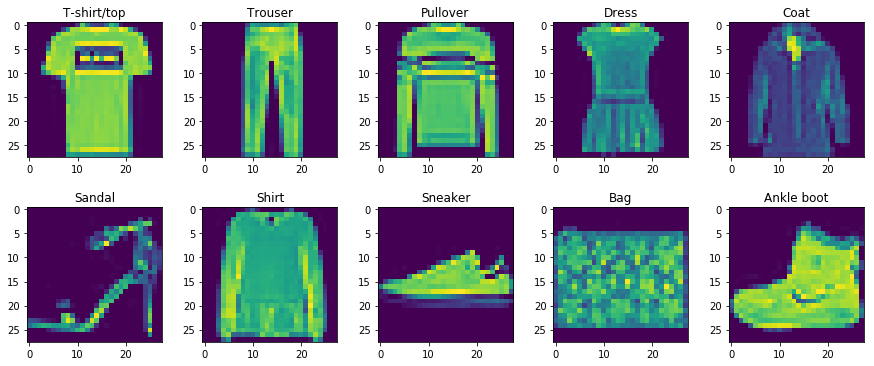

In [23]:
# Utility functions

def flatten(arr):
    arr = arr.reshape(arr.shape[0], -1)
    return arr

def plot_labels(data, labels, flatten=False):

    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    uniq_labels = np.unique(labels)

    fig, ax = plt.subplots(2,5, figsize=(15, 6))
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    ax = ax.reshape(-1)

    for i, label in enumerate(uniq_labels):

        img = data[np.where(labels == label)[0][0]]

        ax[i].set_title(class_names[label])
        
        if flatten:
            img = img.reshape(28, 28)

        ax[i].imshow(img)
    
    plt.show()

plot_labels(train_images, train_labels)

In [24]:
train_images = flatten(train_images)
test_images = flatten(test_images)

train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1, shuffle=True)
train_labels.shape, val_labels.shape

((54000,), (6000,))

In [25]:
sweep_config = {
  "name": "Sweep Test Master",
  "method": "grid",
  "parameters": {
        "epochs": {
            "values": [5, 10]
        },
        "n_layers": {
            "values": [3, 4, 5]
        }
    }
}

sweep_id = wandb.sweep(sweep_config)

Create sweep with ID: gi2ksmfk
Sweep URL: https://wandb.ai/avyay/uncategorized/sweeps/gi2ksmfk


In [26]:
wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: kv1shhj5 with config:
wandb: 	epochs: 5
wandb: 	n_layers: 3
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch: 1 Train Loss: 0.707586 Train Accuracy: 0.744576 Val Loss: 0.479191 Val Accuracy: 0.829953
Epoch: 2 Train Loss: 0.463202 Train Accuracy: 0.832161 Val Loss: 0.423518 Val Accuracy: 0.848238
Epoch: 3 Train Loss: 0.413866 Train Accuracy: 0.850007 Val Loss: 0.402035 Val Accuracy: 0.853890
Epoch: 4 Train Loss: 0.384985 Train Accuracy: 0.860264 Val Loss: 0.384555 Val Accuracy: 0.860539
Epoch: 5 Train Loss: 0.365588 Train Accuracy: 0.866465 Val Loss: 0.371196 Val Accuracy: 0.865525

Model trained successfully!


epoch,5
train_loss,0.36559
train_acc,0.86647
val_loss,0.3712
val_acc,0.86553
_runtime,11
_timestamp,1615404781
_step,4


epoch,▁▃▅▆█
train_loss,█▃▂▁▁
train_acc,▁▆▇██
val_loss,█▄▃▂▁
val_acc,▁▅▆▇█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: g4dlo03v with config:
wandb: 	epochs: 5
wandb: 	n_layers: 4
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch: 1 Train Loss: 0.723787 Train Accuracy: 0.735560 Val Loss: 0.477161 Val Accuracy: 0.827959
Epoch: 2 Train Loss: 0.465409 Train Accuracy: 0.832439 Val Loss: 0.419655 Val Accuracy: 0.846576
Epoch: 3 Train Loss: 0.416455 Train Accuracy: 0.849211 Val Loss: 0.388514 Val Accuracy: 0.861536
Epoch: 4 Train Loss: 0.386872 Train Accuracy: 0.859282 Val Loss: 0.371048 Val Accuracy: 0.869681
Epoch: 5 Train Loss: 0.366316 Train Accuracy: 0.866669 Val Loss: 0.362729 Val Accuracy: 0.872673

Model trained successfully!


epoch,5
train_loss,0.36632
train_acc,0.86667
val_loss,0.36273
val_acc,0.87267
_runtime,14
_timestamp,1615404800
_step,4


epoch,▁▃▅▆█
train_loss,█▃▂▁▁
train_acc,▁▆▇██
val_loss,█▄▃▂▁
val_acc,▁▄▆██
_runtime,▁▃▅▇█
_timestamp,▁▃▅▇█
_step,▁▃▅▆█


wandb: Agent Starting Run: d6gj8f92 with config:
wandb: 	epochs: 5
wandb: 	n_layers: 5
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch: 1 Train Loss: 0.823852 Train Accuracy: 0.693091 Val Loss: 0.560746 Val Accuracy: 0.776928
Epoch: 2 Train Loss: 0.499495 Train Accuracy: 0.820683 Val Loss: 0.465609 Val Accuracy: 0.826130
Epoch: 3 Train Loss: 0.438374 Train Accuracy: 0.841010 Val Loss: 0.430273 Val Accuracy: 0.842254
Epoch: 4 Train Loss: 0.403838 Train Accuracy: 0.853784 Val Loss: 0.411828 Val Accuracy: 0.842919
Epoch: 5 Train Loss: 0.381374 Train Accuracy: 0.860375 Val Loss: 0.378228 Val Accuracy: 0.858211

Model trained successfully!


epoch,5
train_loss,0.38137
train_acc,0.86037
val_loss,0.37823
val_acc,0.85821
_runtime,11
_timestamp,1615404816
_step,4


epoch,▁▃▅▆█
train_loss,█▃▂▁▁
train_acc,▁▆▇██
val_loss,█▄▃▂▁
val_acc,▁▅▇▇█
_runtime,▁▄▅▇█
_timestamp,▁▄▅▇█
_step,▁▃▅▆█


wandb: Agent Starting Run: s3cec4oi with config:
wandb: 	epochs: 10
wandb: 	n_layers: 3
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch: 1 Train Loss: 0.724059 Train Accuracy: 0.734764 Val Loss: 0.531889 Val Accuracy: 0.808344
Epoch: 2 Train Loss: 0.464440 Train Accuracy: 0.829736 Val Loss: 0.465766 Val Accuracy: 0.828624
Epoch: 3 Train Loss: 0.411830 Train Accuracy: 0.847823 Val Loss: 0.451901 Val Accuracy: 0.833777
Epoch: 4 Train Loss: 0.381701 Train Accuracy: 0.859338 Val Loss: 0.442429 Val Accuracy: 0.840592
Epoch: 5 Train Loss: 0.362238 Train Accuracy: 0.866614 Val Loss: 0.426902 Val Accuracy: 0.848238
Epoch: 6 Train Loss: 0.346477 Train Accuracy: 0.870723 Val Loss: 0.417017 Val Accuracy: 0.852560
Epoch: 7 Train Loss: 0.334334 Train Accuracy: 0.876574 Val Loss: 0.421026 Val Accuracy: 0.851895
Epoch: 8 Train Loss: 0.324204 Train Accuracy: 0.879961 Val Loss: 0.400390 Val Accuracy: 0.858211
Epoch: 9 Train Loss: 0.315980 Train Accuracy: 0.883368 Val Loss: 0.406612 Val Accuracy: 0.859043
Epoch: 10 Train Loss: 0.308049 Train Accuracy: 0.884849 Val Loss: 0.396572 Val Accuracy: 0.863531

Model trained successfully!


epoch,10
train_loss,0.30805
train_acc,0.88485
val_loss,0.39657
val_acc,0.86353
_runtime,16
_timestamp,1615404837
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▁▁▁▁
train_acc,▁▅▆▇▇▇████
val_loss,█▅▄▃▃▂▂▁▂▁
val_acc,▁▄▄▅▆▇▇▇▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 7ndumqk6 with config:
wandb: 	epochs: 10
wandb: 	n_layers: 4
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch: 1 Train Loss: 0.806429 Train Accuracy: 0.692776 Val Loss: 0.499202 Val Accuracy: 0.824634
Epoch: 2 Train Loss: 0.472711 Train Accuracy: 0.826144 Val Loss: 0.455530 Val Accuracy: 0.837766
Epoch: 3 Train Loss: 0.420084 Train Accuracy: 0.844657 Val Loss: 0.428688 Val Accuracy: 0.848404
Epoch: 4 Train Loss: 0.392173 Train Accuracy: 0.855580 Val Loss: 0.401063 Val Accuracy: 0.858710
Epoch: 5 Train Loss: 0.371741 Train Accuracy: 0.863485 Val Loss: 0.390061 Val Accuracy: 0.860705
Epoch: 6 Train Loss: 0.355661 Train Accuracy: 0.869002 Val Loss: 0.375442 Val Accuracy: 0.866523
Epoch: 7 Train Loss: 0.343848 Train Accuracy: 0.873871 Val Loss: 0.369286 Val Accuracy: 0.867520
Epoch: 8 Train Loss: 0.332831 Train Accuracy: 0.878666 Val Loss: 0.364717 Val Accuracy: 0.871177
Epoch: 9 Train Loss: 0.323380 Train Accuracy: 0.882331 Val Loss: 0.362498 Val Accuracy: 0.869681
Epoch: 10 Train Loss: 0.314731 Train Accuracy: 0.884886 Val Loss: 0.367900 Val Accuracy: 0.870512

Model trained successfully!


epoch,10
train_loss,0.31473
train_acc,0.88489
val_loss,0.3679
val_acc,0.87051
_runtime,16
_timestamp,1615404857
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▂▁▁▁▁
train_acc,▁▆▇▇▇▇████
val_loss,█▆▄▃▂▂▁▁▁▁
val_acc,▁▃▅▆▆▇▇███
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 874lshk1 with config:
wandb: 	epochs: 10
wandb: 	n_layers: 5
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch: 1 Train Loss: 0.890992 Train Accuracy: 0.659730 Val Loss: 0.547724 Val Accuracy: 0.806682
Epoch: 2 Train Loss: 0.522716 Train Accuracy: 0.810704 Val Loss: 0.465211 Val Accuracy: 0.829289
Epoch: 3 Train Loss: 0.449406 Train Accuracy: 0.836326 Val Loss: 0.422801 Val Accuracy: 0.844415
Epoch: 4 Train Loss: 0.410553 Train Accuracy: 0.850211 Val Loss: 0.401962 Val Accuracy: 0.850565
Epoch: 5 Train Loss: 0.385624 Train Accuracy: 0.858949 Val Loss: 0.398798 Val Accuracy: 0.853557
Epoch: 6 Train Loss: 0.368754 Train Accuracy: 0.864207 Val Loss: 0.396831 Val Accuracy: 0.856383
Epoch: 7 Train Loss: 0.353456 Train Accuracy: 0.869354 Val Loss: 0.388774 Val Accuracy: 0.857713
Epoch: 8 Train Loss: 0.342268 Train Accuracy: 0.873889 Val Loss: 0.384002 Val Accuracy: 0.862699
Epoch: 9 Train Loss: 0.333036 Train Accuracy: 0.876203 Val Loss: 0.378483 Val Accuracy: 0.863531
Epoch: 10 Train Loss: 0.324798 Train Accuracy: 0.879499 Val Loss: 0.381444 Val Accuracy: 0.862866

Model trained successfully!


epoch,10
train_loss,0.3248
train_acc,0.8795
val_loss,0.38144
val_acc,0.86287
_runtime,15
_timestamp,1615404876
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
train_acc,▁▆▇▇▇█████
val_loss,█▅▃▂▂▂▁▁▁▁
val_acc,▁▄▆▆▇▇▇███
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
## Load MNIST dataset

In [13]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_images = train_images / 255.0
test_images = test_images / 255.0

print(f"Train samples: {train_images.shape[0]} Test samples: {test_images.shape[0]}")

Train samples: 60000 Test samples: 10000


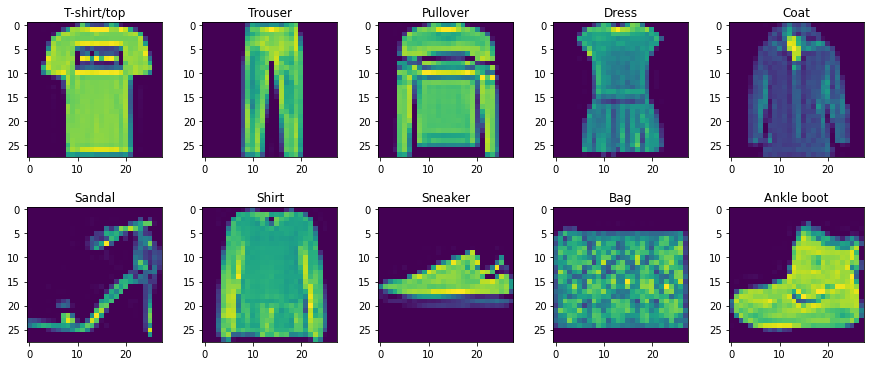

In [14]:
## Utility functions for preprocessing data ##

def flatten(arr):
    arr = arr.reshape(arr.shape[0], -1)
    return arr

def plot_labels(data, labels, flatten=False):

    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    uniq_labels = np.unique(labels)

    fig, ax = plt.subplots(2,5, figsize=(15, 6))
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    ax = ax.reshape(-1)

    for i, label in enumerate(uniq_labels):

        img = data[np.where(labels == label)[0][0]]

        ax[i].set_title(class_names[label])
        
        if flatten:
            img = img.reshape(28, 28)

        ax[i].imshow(img)
    
    plt.show()

plot_labels(train_images, train_labels)

In [15]:
train_images = flatten(train_images)
test_images = flatten(test_images)

train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1, shuffle=True)

print(f"Train samples: {train_labels.shape[0]} Validation samples: {val_labels.shape[0]}")

Train samples: 54000 Validation samples: 6000


In [17]:
# creating an instance of the model
model = NeuralNet([FC(784, 64), ReLU(), FC(64, 10)])

# setting up the loss and the optimizer
optimizer = SGD()
loss = CrossEntropyLossFromLogits()

# compiling the model
model.compile(loss, optimizer)

# training and validation
model.fit(train_images, train_labels, val_images, val_labels, batch_size=128, epochs=5)

Epoch: 1 Train Loss: 0.6722545449003707 Train Accuracy: 0.7659106296547055 Val Loss: 0.5032093439514117 Val Accuracy: 0.8209061550151976
Epoch: 2 Train Loss: 0.4753314078292404 Train Accuracy: 0.8319704214624237 Val Loss: 0.4503441649326295 Val Accuracy: 0.8365786474164134
Epoch: 3 Train Loss: 0.4290909648269082 Train Accuracy: 0.8473521073121192 Val Loss: 0.4221163670308154 Val Accuracy: 0.8472644376899695
Epoch: 4 Train Loss: 0.40248318952485135 Train Accuracy: 0.8564949009817198 Val Loss: 0.403969582743929 Val Accuracy: 0.8551006838905776
Epoch: 5 Train Loss: 0.38354867623408406 Train Accuracy: 0.8624613871022342 Val Loss: 0.3915943723543957 Val Accuracy: 0.8594462386018237

Model trained successfully!
